In [ ]:
from util import *
from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, Bidirectional, LSTM, Reshape, RepeatVector, TimeDistributed
from keras.layers import BatchNormalization, Activation
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
import tensorflow_gan as tfgan
import tensorflow as tf
tf.compat.v1.enable_eager_execution() 

import matplotlib.pyplot as plt

import sys

import numpy as np
import pandas as pd

import os

from PIL import Image

# Load Data
Loading from preprocessed numpy array

# Creating GAN

In [6]:
class LSTMGAN():
    def __init__(self, step_i, step_o, f, data):
        self.data = data
        self.step_input = step_i
        self.step_output = step_o
        self.feature_len = f
        self.in_shape = (self.step_input, self.feature_len)
        self.out_shape = (self.step_output, self.feature_len)
        self.dis_shape = (self.step_input+self.step_output, self.feature_len)

        optimizer = Adam(0.0001, 0.4)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy',
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()
        # Trains the generator to imitate input data
        self.generator.compile(loss='mean_squared_error',
            optimizer=optimizer)
        
        # The generator takes noise as input and generates song
        noise = Input(shape=self.in_shape)
        gen_output = self.generator(noise)
        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator takes generated images as input and determines validity
        valid = self.discriminator(merge_time_series(noise, gen_output))

        # The combined model  (stacked generator and discriminator)
        # Trains the generator to fool the discriminator
        self.combined = Model(noise, valid)
        
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)
        
        

    def build_generator(self):

        model = Sequential()
        model.add(Bidirectional(LSTM(128, return_sequences=True), input_shape=self.in_shape))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.2))
        model.add(Bidirectional(LSTM(128)))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(self.out_shape[0] * self.out_shape[1]))
        model.add(Reshape(self.out_shape))
        # model.summary()

        noise = Input(shape=self.in_shape)
        img = model(noise)

        return Model(noise, img)

    def build_discriminator(self):

        model = Sequential()
        
        model.add(Bidirectional(LSTM(128, activation = 'relu', return_sequences=True), input_shape=self.dis_shape))
        model.add(Dropout(0.4))
        model.add(TimeDistributed(Dense(128, activation = 'relu')))
        model.add(Dense(1, activation = 'linear'))
        #model.summary()

        img = Input(shape=self.dis_shape)
        validity = model(img)

        return Model(img, validity)
    
    
    def train(self, epochs, batch_size=128, save_interval=50, log_interval=50):
    

        # Load the dataset
        (X_train_input, X_train_output) = split_time_series(self.step_input, self.step_output, self.data)

        # normalize

        # Adversarial ground truths
        valid = np.ones(batch_size)
        fake = np.zeros(batch_size)

        for epoch in range(epochs):

            # ---------------------
            #  Train Discriminator
            # ---------------------
            # Select a random half of songs
            idx = np.random.randint(0, X_train_input.shape[0], batch_size)
            real_input= X_train_input[idx]
            real_output= X_train_output[idx]
            
           
            
            (real_input, scalers) = batch_standardize(real_input)
            real_output = batch_transform(real_output, scalers)
            
            # Sample noise and generate a batch of new prices
            noise = np.random.normal(0, 1, (batch_size,self.step_input,self.feature_len))
            gen_output = self.generator.predict(noise, batch_size = batch_size)
            real_series = merge_time_series(real_input,real_output)
            fake_series = merge_time_series(real_input,gen_output)

            # Train the discriminator (real classified as ones and generated as zeros)
            d_loss_real = self.discriminator.train_on_batch(real_series, valid)
            d_loss_fake = self.discriminator.train_on_batch(fake_series, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # ---------------------
            #  Train Generator
            # ---------------------
            # First training (wants generator to imitate real data)
            g_loss1 = self.generator.train_on_batch( np.array(real_input), np.array(real_output))
            
            # Second training (wants discriminator to mistake songs as real)
            g_loss2 = self.combined.train_on_batch(noise, valid)
            g_loss = 0.5 * np.add(g_loss1, g_loss2)



            # Plot the progress
            if log_interval and epoch % log_interval == 0:
                print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))
                print("input:\n", scalers[0].inverse_transform( real_input[0]))
                print("fake_output:\n", scalers[0].inverse_transform( gen_output[0]))
                print("real_output:\n", scalers[0].inverse_transform( real_output[0]))

            # If at save interval => save model
            if epoch % save_interval == 0:
                self.generator.save("LSTM_generator.h5")

# Model Summary
I couldn't train the model on this online notebook so I trained it locally for 1000 epochs and uploaded the h5 file.

In [7]:
data = load_data("./data_stock/Dowjones_average.csv")
step_i = 5
step_o = 5
f = 4
lstmgan = LSTMGAN(step_i, step_o, f , data)
lstmgan.train(epochs=10000, batch_size=50, save_interval=1000, log_interval=1000)

0 [D loss: 1.634070, acc.: 57.30%] [G loss: 16.294600]
input:
 [[23543.66 23598.08 23211.38 23537.68]
 [23600.72 23649.72 23233.32 23504.35]
 [23690.57 24040.58 23683.44 23949.76]
 [23698.93 23698.93 23095.35 23390.77]
 [23690.66 24008.99 23504.09 23719.37]]
fake_output:
 [[23644.39  23798.34  23344.877 23621.725]
 [23646.312 23802.541 23342.387 23618.85 ]
 [23644.527 23796.54  23343.389 23624.033]
 [23645.004 23797.396 23349.408 23620.191]
 [23645.281 23798.8   23348.906 23622.77 ]]
real_output:
 [[22893.47 23513.4  22682.99 23433.57]
 [23537.44 23617.24 22634.45 22653.86]
 [21693.63 22783.45 21693.63 22679.99]
 [21285.93 21447.81 20863.09 21052.53]
 [20819.46 21477.77 20735.02 21413.44]]
1000 [D loss: 0.662762, acc.: 57.90%] [G loss: 3.153028]
input:
 [[28022.51 28174.78 27447.08 27534.58]
 [27711.71 28206.21 27704.54 27940.47]
 [27925.23 27925.23 27464.9  27500.89]
 [28341.05 28539.75 27664.68 28133.31]
 [29090.7  29199.35 28074.76 28292.73]]
fake_output:
 [[26764.783 27494.36  2714

Loading pretrained model

Installinging Mido Library

# Generate Stock Prices
Generating random input and letting model predict output

In [11]:
# import importlib
# import lib.reload(util)
# from util import *

(real_input, real_output) = split_time_series_disjoint(step_i, step_o, data)
MA5 = moving_average(5, data)
MA5 = MA5[:round(len(MA5)/step_o) * step_o]
(stzd_input, scalers) = batch_standardize(real_input)

stzd_pred_output = lstmgan.generator(tf.convert_to_tensor(stzd_input)).numpy()

#TODO: fix MA5
pred_output = batch_inverse_transform(stzd_pred_output, scalers)
stzd_real_output = batch_transform(real_output, scalers)
stzd_MA5 = batch_transform(MA5.reshape(-1, step_o, MA5.shape[-1]), scalers)

print(f'predicted price:\n{pred_output[0]},\nreal price:\n{real_output[0]},\nMA5:\n{MA5[:5]} \
       ,\nstandardized predicted price:\n{stzd_pred_output[0]} \
       ,\nstandardized real price:\n{stzd_real_output[0]} \
       ,\nstandardized MA5:\n{stzd_MA5[:5]}')

predicted price:
[[35216.94  35809.465 35223.418 35063.152]
 [35357.973 35730.043 35396.86  35040.844]
 [35446.055 35877.945 35493.133 35071.03 ]
 [35482.78  36017.344 35734.004 35086.047]
 [35695.21  35878.074 35643.996 35085.92 ]],
real price:
[[35661.76 35661.76 35262.02 35368.47]
 [35996.43 35996.43 35641.49 35911.81]
 [36312.49 36513.88 36044.22 36113.62]
 [36336.16 36453.49 36168.15 36290.32]
 [36058.85 36271.47 35769.38 36252.02]],
MA5:
[[34694.78  34989.346 34122.202 34534.328]
 [34989.804 35203.49  34465.502 34748.476]
 [35374.968 35518.578 34963.734 35057.938]
 [35697.128 35842.02  35326.668 35427.588]
 [35943.828 36034.678 35626.274 35742.574]]        ,
standardized predicted price:
[[1.0127916 1.7870785 1.5938575 1.7943361]
 [1.2863389 1.6140128 1.8448924 1.718645 ]
 [1.4571835 1.9362991 1.9842305 1.8210616]
 [1.5284195 2.240052  2.3328612 1.8720196]
 [1.9404525 1.9365771 2.202585  1.8715897]]        ,
standardized real price:
[[1.87556853 1.46521913 1.6497291  2.83029659]


# Plot


In [12]:
#transform everything into columns                
stzd_pred_data = columnify(stzd_pred_output)
stzd_real_data = columnify(stzd_real_output)
stzd_MA5_data = columnify(stzd_MA5)
pred_data = columnify(pred_output)
real_data = columnify(real_output) 
MA5_data = columnify(MA5)

titles = ["Open Price", "High Price", "Low Price", "Close Price"]
columns = len(titles)

mae = MAE(stzd_real_data[3],stzd_pred_data[3])
rmse = RMSE(stzd_real_data[3],stzd_pred_data[3])
mape = MAPE(stzd_real_data[3],stzd_pred_data[3])
ar = AR(stzd_real_data[3],stzd_pred_data[3])

MA5_mae = MAE(stzd_real_data[3],stzd_MA5_data[3])
MA5_rmse = RMSE(stzd_real_data[3],stzd_MA5_data[3])
MA5_mape = MAPE(stzd_real_data[3],stzd_MA5_data[3])
MA5_ar = AR(stzd_real_data[3],stzd_MA5_data[3])

print('LSTM: MAE=',mae,'RMSE=',rmse,'MAPE=',mape,'AR=',ar)
print('MA5: MAE=',MA5_mae,'RMSE=',MA5_rmse,'MAPE=',MA5_mape,'AR=',MA5_ar)


LSTM: MAE= 1.3449749990881081 RMSE= 2.0665249733119486 MAPE= 2.0889140045003463 AR= 0.40920855136019524
MA5: MAE= 1.8390284635993823 RMSE= 2.7810772115440776 MAPE= 1.1106831179268266 AR= 0.251943556101503


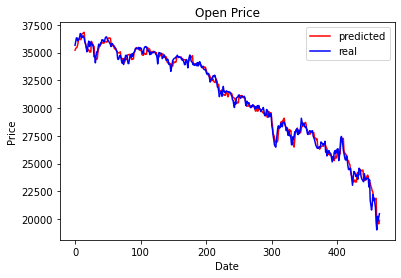

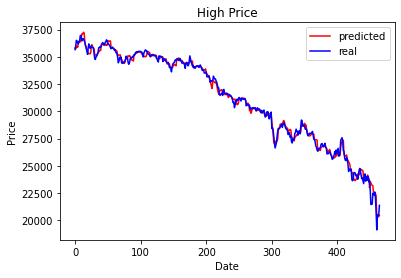

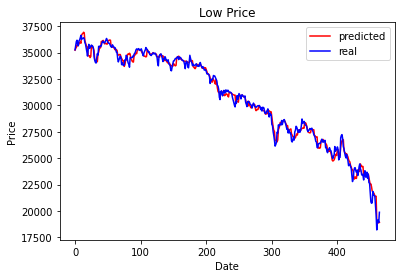

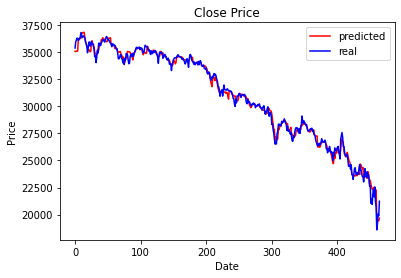

In [13]:
for i in range(columns):
    length = len(pred_data[i])
    plt.plot(range(length), pred_data[i], color ='r', 
             label ='predicted')

    plt.plot(range(length), real_data[i], color ='b', 
             label ='real')

    # naming of x-axis and y-axis
    plt.xlabel('Date')
    plt.ylabel('Price')

    # naming the title of the plot
    plt.title(titles[i])

    plt.legend()
    plt.show()